Imports

In [11]:
import os
import re
import numpy as np
import pandas as pd
from datetime import datetime
# Import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns


# Reuse TLE helpers
from utils.tle_utils import (
    parse_norad_from_tle1,
    parse_line2_params,
)


Load all Data from DATA repository

Pre-process datasets

In [33]:

# Path to your DATA repository
data_dir = "DATA"

# Get all CSV files in the directory
csv_files = [f for f in os.listdir(data_dir) if f.endswith(".csv")]

# Read all CSV files into a dictionary of DataFrames
dataframes = {}
for file in csv_files:
    file_path = os.path.join(data_dir, file)
    # Low-memory False to avoid mixed-type warnings; let us coerce manually later
    df = pd.read_csv(file_path, low_memory=False)
    dataframes[file] = df

# Preview
for name, df in dataframes.items():
    print(f"\n--- {name} ---")
    print(df.head())



--- space_debris_the_origin_test.csv ---
   Object_ID_or_EpochOffset  Julian_Date  Eccentricity  Inclination_deg  \
0                   -2705.0     42218.91      0.044029          17.2489   
1                   -1175.0     42196.05      0.038860          18.2316   
2                    6245.0     42262.75      0.040401           7.0164   
3                     955.0     42274.76      0.144582          11.9657   
4                    1445.0     42249.25      0.070723          12.2470   

   RAAN_deg  Arg_of_Perigee_deg  Mean_Anomaly_deg  
0    8.9998             53.0336           18.2197  
1   31.7042            100.0266          358.4582  
2  213.1170            323.9927          276.8607  
3  275.5726            113.6497           22.3424  
4  178.3093            165.3546           19.7580  

--- space_debris_the_origin_train.csv ---
   Object_ID_or_EpochOffset  Julian_Date  Eccentricity  Inclination_deg  \
0                   -1935.0     42276.74      0.050749          13.4614   
1 

In [34]:
# Helper: robust datetime conversion for known date columns
DATE_COLS = {"EPOCH", "LAUNCH", "DECAY_EPOCH", "TCA", "CREATED", "DECAY", "TLE_EPOCH"}

# Helper: TLE parsing using fixed-column positions
# References: Celestrak TLE format

def parse_tle_epoch(line1: str):
    """
    Parse epoch year (YY) and day of year (DDDDDD.DDDDD) from TLE line 1.
    Returns (epoch_year, epoch_day) as (int or None, float or None).
    Columns (0-based slices): year [18:20], day [20:32].
    """
    if not isinstance(line1, str) or len(line1) < 32:
        return None, None
    try:
        yy = line1[18:20]
        day = line1[20:32]
        epoch_year = int(yy)
        # Convert 2-digit year to full year (assume 1957-2056 per TLE convention)
        full_year = 1900 + epoch_year if epoch_year >= 57 else 2000 + epoch_year
        epoch_day = float(day.strip()) if day.strip() else None
        return full_year, epoch_day
    except Exception:
        return None, None


def parse_line2_more(line2: str):
    """
    Parse RAAN, Eccentricity, Arg of Perigee, Mean Anomaly from TLE line 2.
    Fixed columns (0-based):
      RAAN [17:25]
      Ecc  [26:33] (implied decimal: 0.x)
      ArgP [34:42]
      MeanA[43:51]
    Returns (raan_deg, ecc, argp_deg, meana_deg)
    """
    if not isinstance(line2, str) or len(line2) < 51:
        return None, None, None, None
    try:
        raan = float(line2[17:25].strip()) if line2[17:25].strip() else None
        ecc_str = line2[26:33].strip()
        ecc = float(f"0.{ecc_str}") if ecc_str else None
        argp = float(line2[34:42].strip()) if line2[34:42].strip() else None
        meana = float(line2[43:51].strip()) if line2[43:51].strip() else None
        return raan, ecc, argp, meana
    except Exception:
        return None, None, None, None


def ensure_datetime(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.columns:
        if col.upper() in DATE_COLS:
            df[col] = pd.to_datetime(df[col], errors="coerce", utc=True)
    return df


def ensure_numeric(df: pd.DataFrame) -> pd.DataFrame:
    # Attempt to convert obvious numeric columns (excluding identifiers that are alphanumeric)
    for col in df.columns:
        if df[col].dtype == object:
            # Skip columns with TLE lines or IDs that are clearly non-numeric
            if col.upper() in {"LINE1", "LINE2", "TLE_LINE1", "TLE_LINE2", "OBJECT_ID"}:
                continue
            # Try numeric conversion
            converted = pd.to_numeric(df[col], errors="ignore")
            df[col] = converted
    return df


def standardize_ids(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create/standardize NORAD_CAT_ID column as integer where possible.
    Sources: NORAD_CAT_ID, OBJECT_NUMBER, OBJECT_ID, or parsed from TLE line1.
    """
    norad = None
    # Start from existing NORAD_CAT_ID or OBJECT_NUMBER
    for candidate in [
        "NORAD_CAT_ID", "OBJECT_NUMBER", "NORAD_ID", "CATNR", "NORAD",
    ]:
        if candidate in df.columns:
            try:
                temp = pd.to_numeric(df[candidate], errors="coerce").astype("Int64")
                norad = temp if norad is None else norad.fillna(temp)
            except Exception:
                pass
    # OBJECT_ID sometimes contains the Launch ID, not NORAD; do not parse number from it directly.

    # Parse from TLE line1 where available
    line1_col = "LINE1" if "LINE1" in df.columns else ("TLE_LINE1" if "TLE_LINE1" in df.columns else None)
    if line1_col:
        parsed = df[line1_col].apply(lambda x: parse_norad_from_tle1(x) if isinstance(x, str) else None)
        parsed = pd.Series(parsed, index=df.index, dtype="float").astype("Int64")
        norad = parsed if norad is None else norad.fillna(parsed)

    if norad is not None:
        df["NORAD_CAT_ID_STD"] = norad
    return df


def parse_tle_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    If TLE columns exist, parse and add key orbital parameters.
    """
    line1_col = None
    line2_col = None
    # Detect variants
    if "line1" in df.columns and "line2" in df.columns:
        line1_col, line2_col = "line1", "line2"
    elif "LINE1" in df.columns and "LINE2" in df.columns:
        line1_col, line2_col = "LINE1", "LINE2"
    elif "TLE_LINE1" in df.columns and "TLE_LINE2" in df.columns:
        line1_col, line2_col = "TLE_LINE1", "TLE_LINE2"

    if line1_col and line2_col:
        # Epoch Year/Day
        epochs = df[line1_col].apply(lambda x: parse_tle_epoch(x))
        df["TLE_EPOCH_YEAR"] = [e[0] for e in epochs]
        df["TLE_EPOCH_DOY"] = [e[1] for e in epochs]
        # Inclination and Mean Motion from utils
        inc_mm = df[line2_col].apply(lambda x: parse_line2_params(x))
        df["INCLINATION_DEG"] = [p[0] for p in inc_mm]
        df["MEAN_MOTION_REV_PER_DAY"] = [p[1] for p in inc_mm]
        # More params
        raan_ecc_argp_meana = df[line2_col].apply(lambda x: parse_line2_more(x))
        df["RAAN_DEG"] = [p[0] for p in raan_ecc_argp_meana]
        df["ECCENTRICITY"] = [p[1] for p in raan_ecc_argp_meana]
        df["ARG_OF_PERIGEE_DEG"] = [p[2] for p in raan_ecc_argp_meana]
        df["MEAN_ANOMALY_DEG"] = [p[3] for p in raan_ecc_argp_meana]
    return df


def handle_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    # DECAY missing -> informative: not decayed
    if "DECAY" in df.columns:
        # Convert DECAY to datetime first (if not already converted)
        df["DECAY"] = pd.to_datetime(df["DECAY"], errors="coerce", utc=True)
        df["HAS_DECAYED"] = df["DECAY"].notna()
    # For other columns, we avoid blind imputation here; leave NaNs, but could fill booleans
    # If there are entirely empty columns, drop them
    empty_cols = [c for c in df.columns if df[c].isna().all()]
    if empty_cols:
        df = df.drop(columns=empty_cols)
    return df


preprocessed = {}
for name, df in dataframes.items():
    df2 = df.copy()
    df2 = ensure_datetime(df2)
    df2 = ensure_numeric(df2)
    df2 = parse_tle_columns(df2)
    df2 = standardize_ids(df2)
    df2 = handle_missing_values(df2)
    clean_name = name.replace(".csv", "")
    preprocessed[clean_name] = df2


# 1. Join TLE + SATCAT (orbital params + metadata)
tle_satcat = preprocessed['spacetrack_tle_latest'].merge(
    preprocessed['spacetrack_satcat'],
    on="NORAD_CAT_ID_STD",
    suffixes=("_tle", "_satcat")
)

# 2. Join SATCAT + Decay (lifetime info)
satcat_decay = preprocessed['spacetrack_satcat'].merge(
    preprocessed['spacetrack_decay_5y'],
    on="NORAD_CAT_ID_STD",
    suffixes=("_satcat", "_decay")
)
# 3. Join CDM + SATCAT (collision warnings + metadata)
# For CDM you have two satellite IDs (SAT_1_ID, SAT_2_ID),
# so you usually join twice: once for SAT 1, once for SAT 2.
cdm_sat1 = preprocessed['spacetrack_cdm_public_30d'].merge(
    preprocessed['spacetrack_satcat'],
    left_on="SAT_1_ID",
    right_on="NORAD_CAT_ID",
    suffixes=("", "_SAT1")
)
cdm_sat2 = preprocessed['spacetrack_cdm_public_30d'].merge(
    preprocessed['spacetrack_satcat'],
    left_on="SAT_2_ID",
    right_on="NORAD_CAT_ID",
    suffixes=("", "_SAT2")
)
# merge them together for full context
cdm_full = cdm_sat1.merge(
    preprocessed['spacetrack_satcat'],
    left_on="SAT_2_ID",
    right_on="NORAD_CAT_ID",
    suffixes=("_SAT1", "_SAT2")
)

preprocessed['tle_satcat'] = tle_satcat
preprocessed['satcat_decay'] = satcat_decay
preprocessed['cdm_full'] = cdm_full

print("\nPreprocessing complete")
for name, df in preprocessed.items():
    cols = [c for c in [
        "NORAD_CAT_ID_STD",
        "TLE_EPOCH_YEAR", "TLE_EPOCH_DOY",
        "INCLINATION_DEG", "RAAN_DEG", "ECCENTRICITY",
        "ARG_OF_PERIGEE_DEG", "MEAN_ANOMALY_DEG", "MEAN_MOTION_REV_PER_DAY",
        "HAS_DECAYED",
    ] if c in df.columns]
    print(f"- {name}: columns -> {cols[:10]}")
    print(df[cols].head() if cols else df.head())



Preprocessing complete
- space_debris_the_origin_test: columns -> []
   Object_ID_or_EpochOffset  Julian_Date  Eccentricity  Inclination_deg  \
0                   -2705.0     42218.91      0.044029          17.2489   
1                   -1175.0     42196.05      0.038860          18.2316   
2                    6245.0     42262.75      0.040401           7.0164   
3                     955.0     42274.76      0.144582          11.9657   
4                    1445.0     42249.25      0.070723          12.2470   

   RAAN_deg  Arg_of_Perigee_deg  Mean_Anomaly_deg  
0    8.9998             53.0336           18.2197  
1   31.7042            100.0266          358.4582  
2  213.1170            323.9927          276.8607  
3  275.5726            113.6497           22.3424  
4  178.3093            165.3546           19.7580  
- space_debris_the_origin_train: columns -> []
   Object_ID_or_EpochOffset  Julian_Date  Eccentricity  Inclination_deg  \
0                   -1935.0     42276.74     

/var/folders/wb/6jxhfpsn4p57vts99m_qytn40000gn/T/ipykernel_86160/1127018978.py:65: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  converted = pd.to_numeric(df[col], errors="ignore")
/var/folders/wb/6jxhfpsn4p57vts99m_qytn40000gn/T/ipykernel_86160/1127018978.py:65: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  converted = pd.to_numeric(df[col], errors="ignore")
/var/folders/wb/6jxhfpsn4p57vts99m_qytn40000gn/T/ipykernel_86160/1127018978.py:65: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  converted = pd.to_numeric(df[col], errors="ignore")
/var/folders/wb/6jxhfpsn4p57vts99m_qytn40000gn/T/ipykernel_86160/1127018978.py:65: FutureWarning: errors='

Univariate Analysis


Derived orbital parameters added (where available): PERIOD_MIN, SEMIMAJOR_AXIS_KM, PERIGEE_ALT_KM, APOGEE_ALT_KM
Datasets with TLE params: ['spacetrack_tle_latest', 'celestrak_debris_tles', 'tle_satcat']

Plotting univariate distributions for: spacetrack_tle_latest

Plotting univariate distributions for: celestrak_debris_tles

Plotting univariate distributions for: tle_satcat


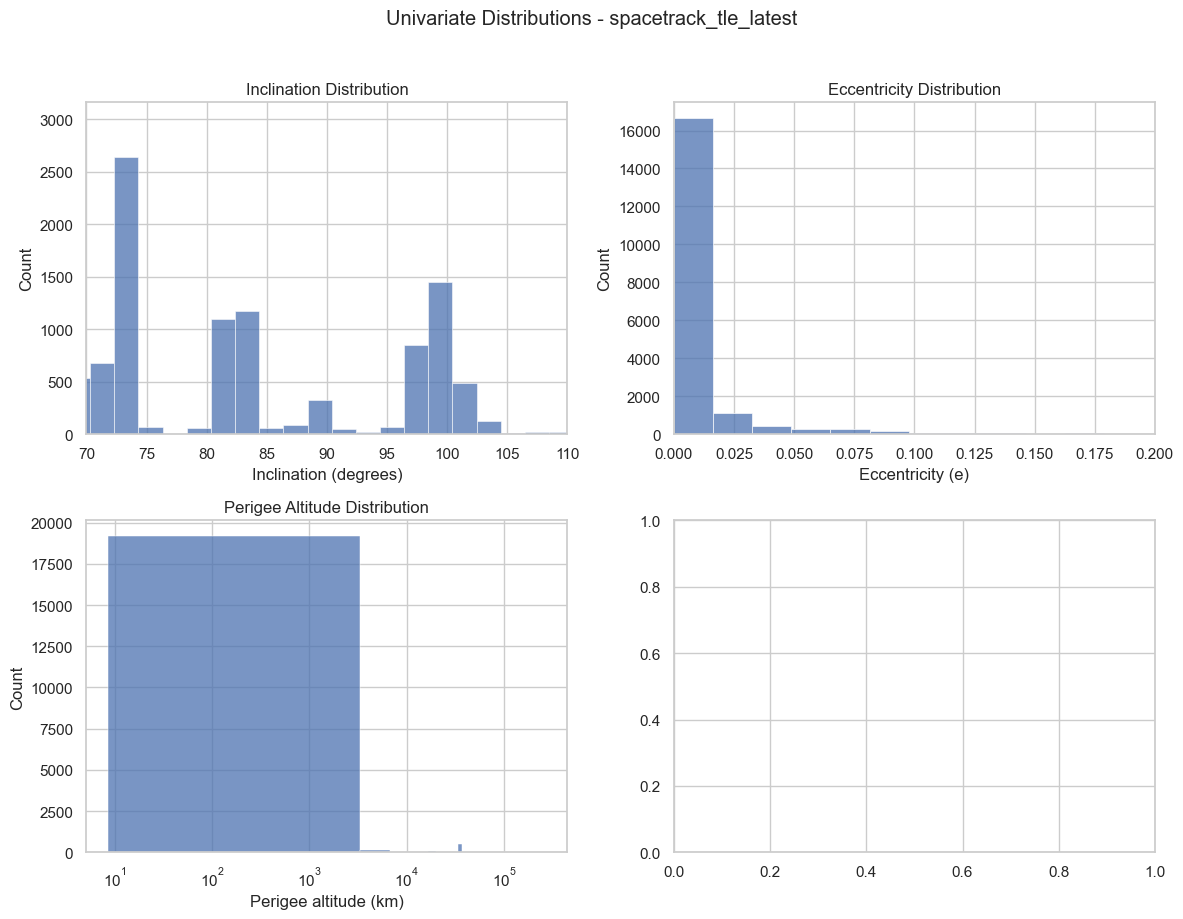

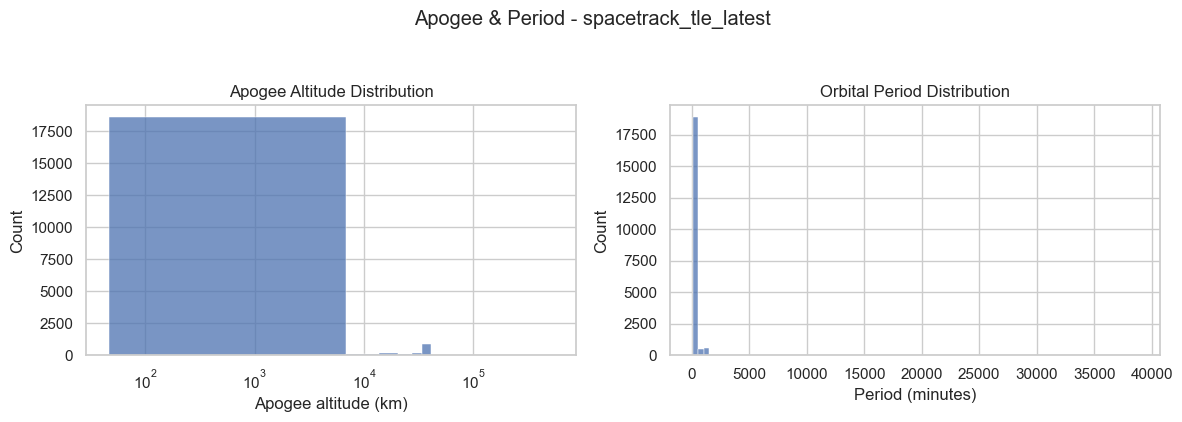

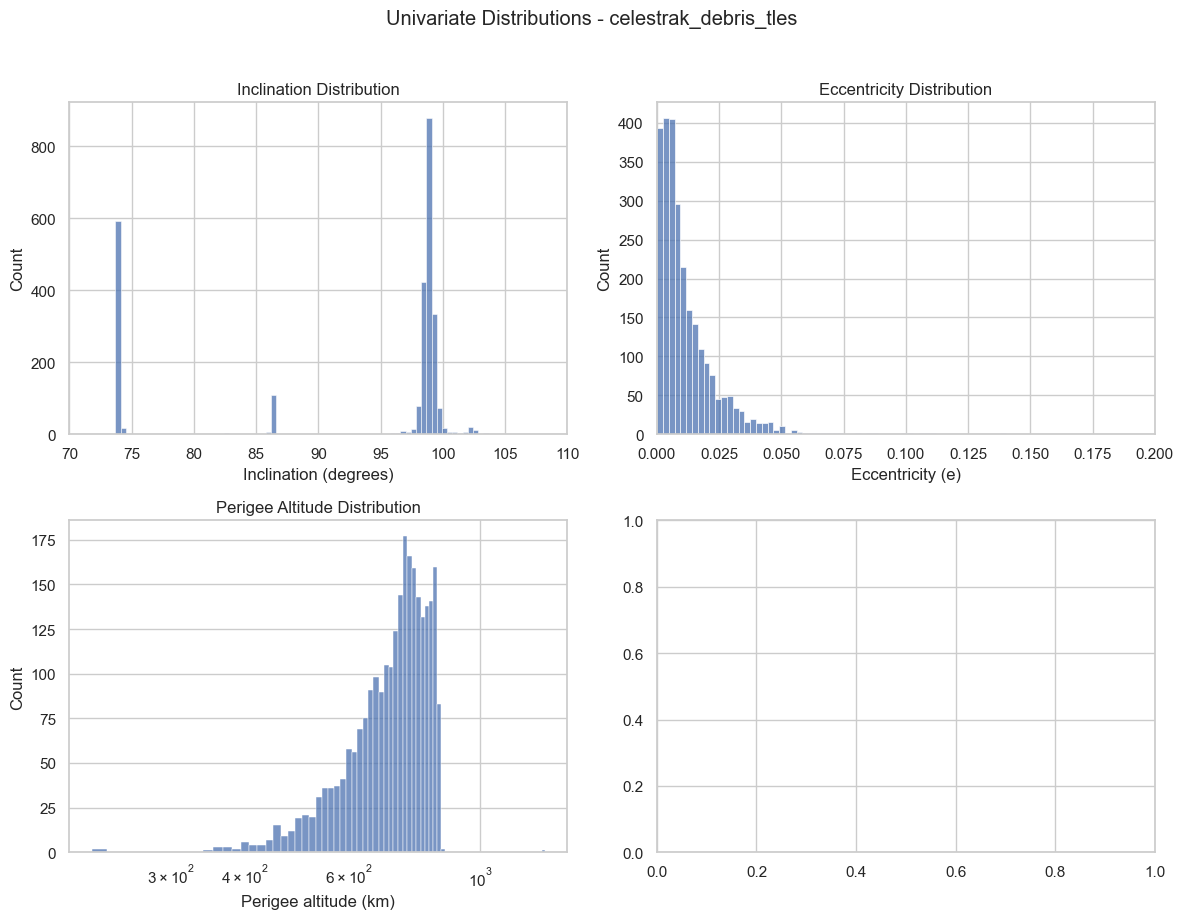

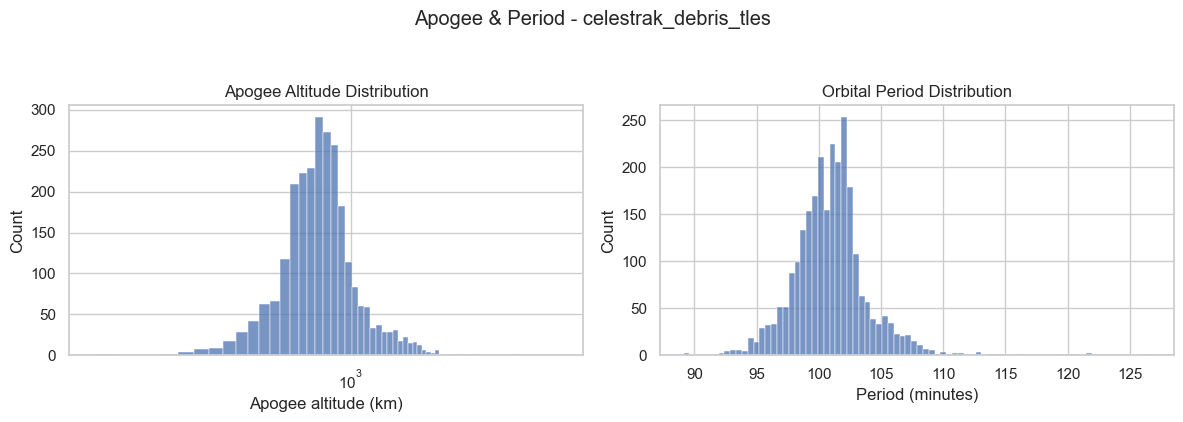

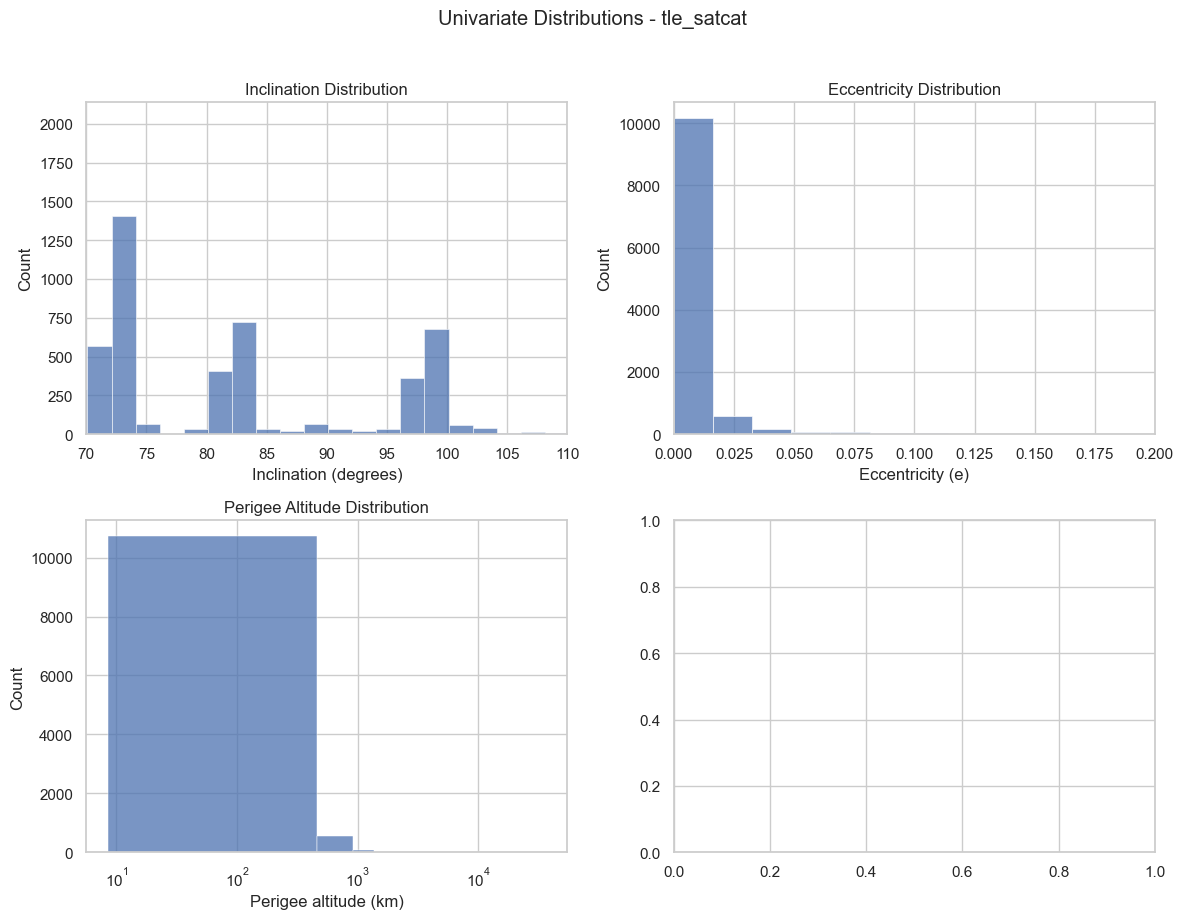

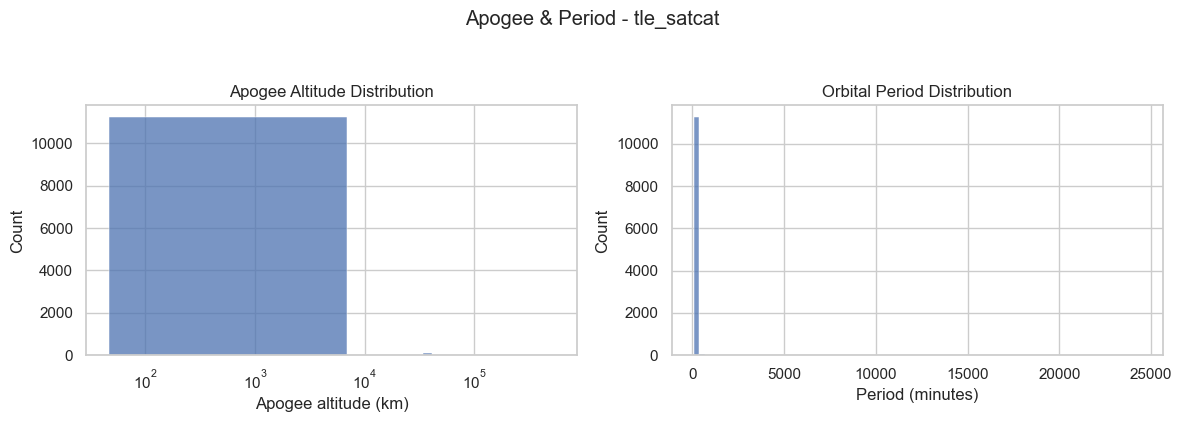

In [35]:
sns.set(style="whitegrid")

# Earth constants (kilometers, seconds)
MU_EARTH_KM3_S2 = 398600.4418  # km^3 / s^2
R_EARTH_KM = 6378.137          # km (equatorial radius)
SECONDS_PER_DAY = 86400.0
TWOPI = 2.0 * np.pi


def add_orbital_derived_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Using MEAN_MOTION_REV_PER_DAY (n, rev/day) and ECCENTRICITY (e),
    compute:
      - PERIOD_MIN (orbital period in minutes)
      - SEMIMAJOR_AXIS_KM (a)
      - PERIGEE_ALT_KM and APOGEE_ALT_KM (altitudes above Earth's surface)
    Only creates columns when inputs are present; leaves existing data untouched otherwise.
    """
    if not {"MEAN_MOTION_REV_PER_DAY", "ECCENTRICITY"}.issubset(df.columns):
        return df

    n = pd.to_numeric(df["MEAN_MOTION_REV_PER_DAY"], errors="coerce")
    e = pd.to_numeric(df["ECCENTRICITY"], errors="coerce")

    # Period in minutes (1440 minutes per day)
    period_min = 1440.0 / n

    # Convert mean motion rev/day to rad/s
    n_rad_s = (n * TWOPI) / SECONDS_PER_DAY
    # Semi-major axis from n: a = (mu / n^2)^(1/3)
    with np.errstate(invalid='ignore', divide='ignore'):
        a_km = (MU_EARTH_KM3_S2 / (n_rad_s ** 2)) ** (1.0 / 3.0)

    # Perigee/Apogee radii and altitudes
    r_p_km = a_km * (1.0 - e)
    r_a_km = a_km * (1.0 + e)
    perigee_alt_km = r_p_km - R_EARTH_KM
    apogee_alt_km = r_a_km - R_EARTH_KM

    # Assign, avoiding SettingWithCopy by using .loc
    df = df.copy()
    df["PERIOD_MIN"] = period_min
    df["SEMIMAJOR_AXIS_KM"] = a_km
    df["PERIGEE_ALT_KM"] = perigee_alt_km
    df["APOGEE_ALT_KM"] = apogee_alt_km
    return df


def plot_hist(ax, series, title, xlabel, bins=60, log_scale=False, xlim=None):
    s = pd.to_numeric(series, errors="coerce").dropna()
    if len(s) == 0:
        ax.text(0.5, 0.5, "No data", ha="center", va="center")
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        return
    if log_scale:
        # Filter out non-positive values for log scale
        s = s[s > 0]
    sns.histplot(s, bins=bins, ax=ax, kde=False, edgecolor=None)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    if log_scale:
        ax.set_xscale('log')
    if xlim is not None:
        ax.set_xlim(xlim)


# Compute derived parameters where possible
for name, df in preprocessed.items():
    preprocessed[name] = add_orbital_derived_columns(df)

print("\nDerived orbital parameters added (where available): PERIOD_MIN, SEMIMAJOR_AXIS_KM, PERIGEE_ALT_KM, APOGEE_ALT_KM")

# Identify datasets that contain TLE-derived columns
datasets_with_tle = []
for name, df in preprocessed.items():
    needed = {"INCLINATION_DEG", "ECCENTRICITY", "MEAN_MOTION_REV_PER_DAY"}
    if needed.issubset(df.columns):
        datasets_with_tle.append((name, df))

print("Datasets with TLE params:", [n for n, _ in datasets_with_tle])

# Plot univariate distributions per dataset
for name, df in datasets_with_tle:
    print(f"\nPlotting univariate distributions for: {name}")

    fig, axes = plt.subplots(2, 2, figsize=(12, 9))
    axes = axes.ravel()

    # 1) Inclination (deg)
    plot_hist(
        axes[0],
        df["INCLINATION_DEG"],
        title="Inclination Distribution",
        xlabel="Inclination (degrees)",
        bins=72,  # 5-degree bins roughly
        log_scale=False,
        xlim=(70, 110)
    )

    # 2) Eccentricity
    plot_hist(
        axes[1],
        df["ECCENTRICITY"],
        title="Eccentricity Distribution",
        xlabel="Eccentricity (e)",
        bins=60,
        log_scale=False,
        xlim=(0, 0.2)
    )

    # Ensure derived columns exist (guarded earlier)
    perigee = pd.to_numeric(df.get("PERIGEE_ALT_KM", pd.Series(dtype=float)), errors="coerce")
    apogee = pd.to_numeric(df.get("APOGEE_ALT_KM", pd.Series(dtype=float)), errors="coerce")
    period = pd.to_numeric(df.get("PERIOD_MIN", pd.Series(dtype=float)), errors="coerce")

    # 3) Perigee altitude (km)
    plot_hist(
        axes[2],
        perigee[perigee >= 0],  # exclude negative/invalid altitudes
        title="Perigee Altitude Distribution",
        xlabel="Perigee altitude (km)",
        bins=80,
        log_scale=True,  # wide range from LEO to GEO+; log helps
        xlim=None
    )

    # 4) Apogee altitude (km)
    fig2, axes2 = plt.subplots(1, 2, figsize=(12, 4))

    plot_hist(
        axes2[0],
        apogee[apogee >= 0],
        title="Apogee Altitude Distribution",
        xlabel="Apogee altitude (km)",
        bins=80,
        log_scale=True,
        xlim=None
    )

    # 5) Period (minutes)
    plot_hist(
        axes2[1],
        period[period > 0],
        title="Orbital Period Distribution",
        xlabel="Period (minutes)",
        bins=80,
        log_scale=False,
        xlim=None
    )

    fig.suptitle(f"Univariate Distributions - {name}", y=1.02)
    fig.tight_layout()
    fig2.suptitle(f"Apogee & Period - {name}", y=1.05)
    fig2.tight_layout()

plt.show()


Physical Characteristics (SpaceTrack SATCAT)

Datasets considered for Physical Characteristics: ['spacetrack_decay_5y', 'spacetrack_tle_latest', 'spacetrack_satcat', 'tle_satcat', 'satcat_decay']

Plotting Physical Characteristics for: spacetrack_decay_5y

Plotting Physical Characteristics for: spacetrack_tle_latest

Plotting Physical Characteristics for: spacetrack_satcat

Plotting Physical Characteristics for: tle_satcat

Plotting Physical Characteristics for: satcat_decay


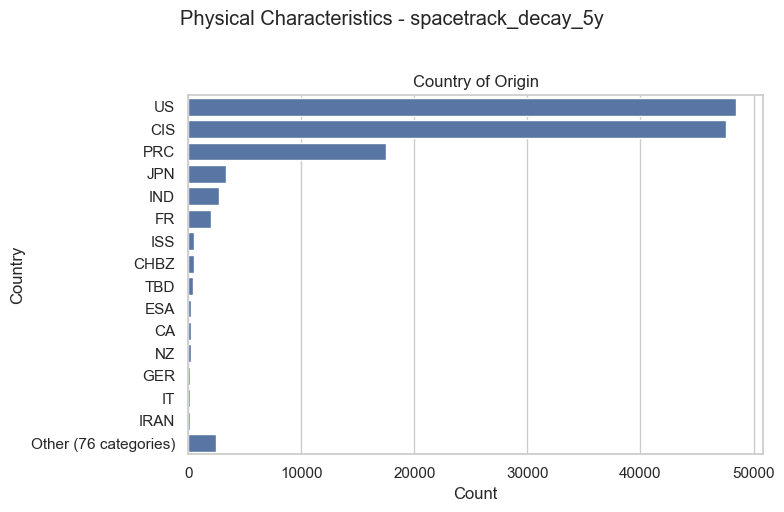

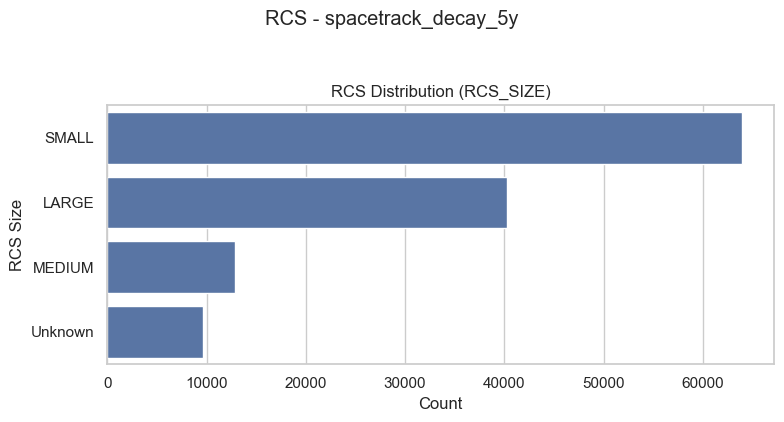

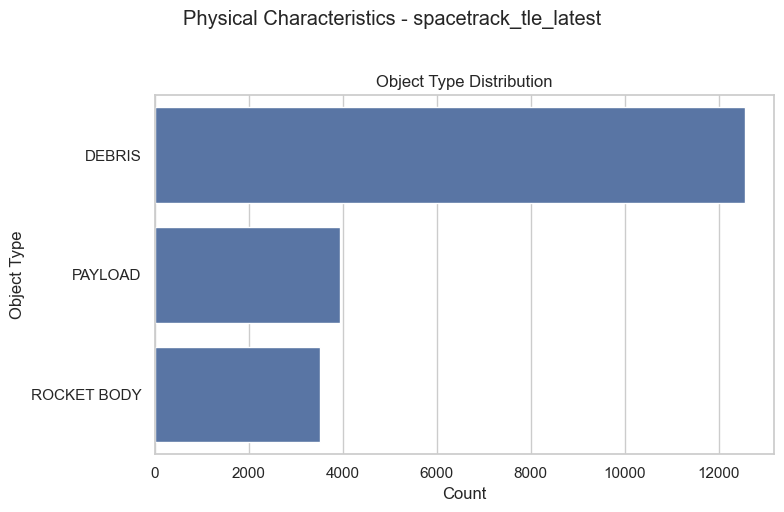

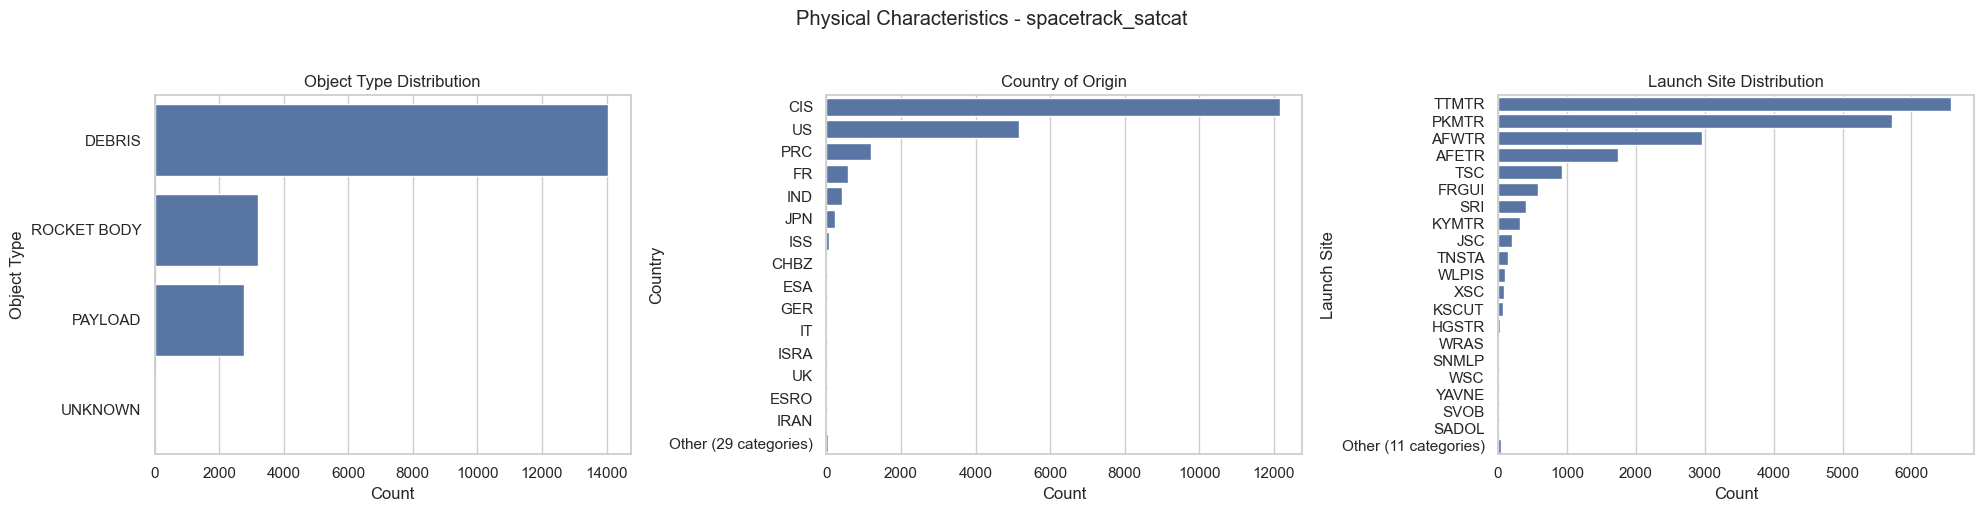

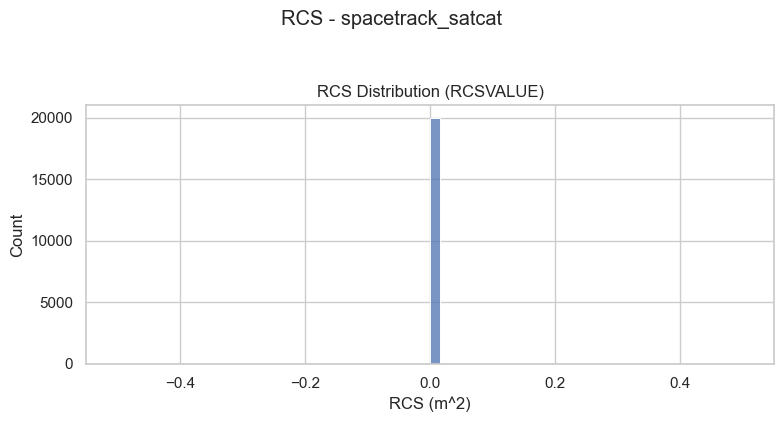

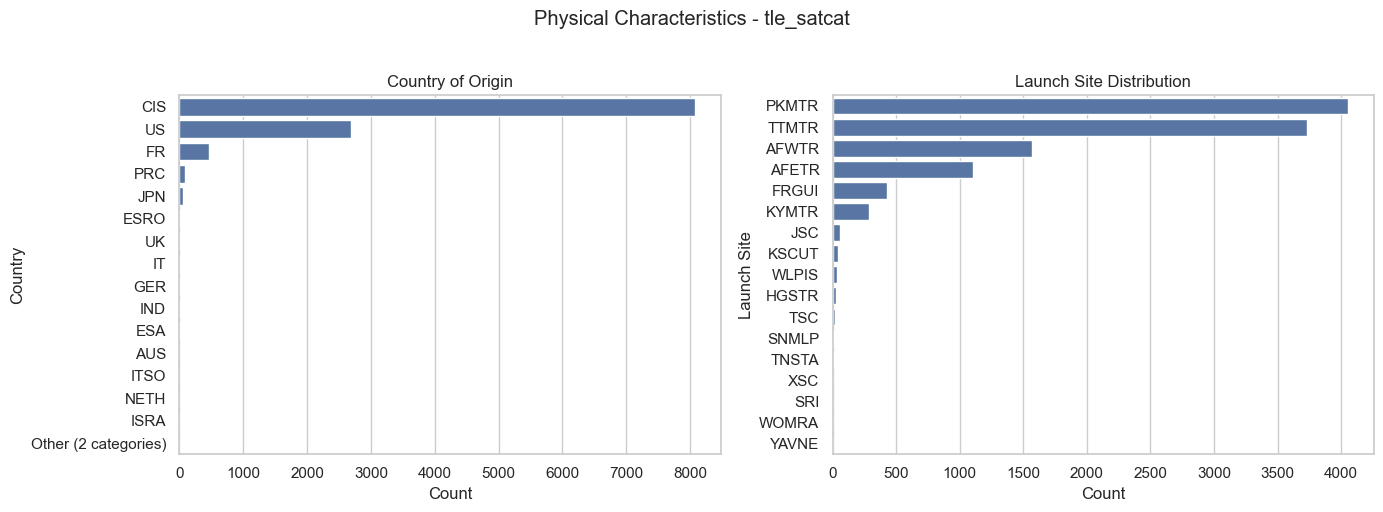

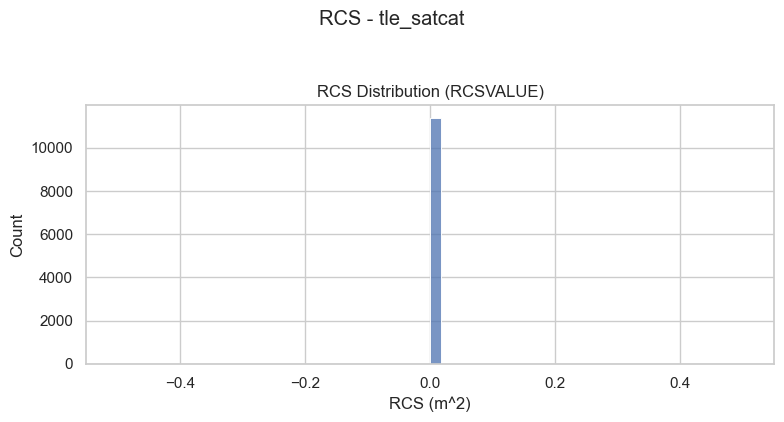

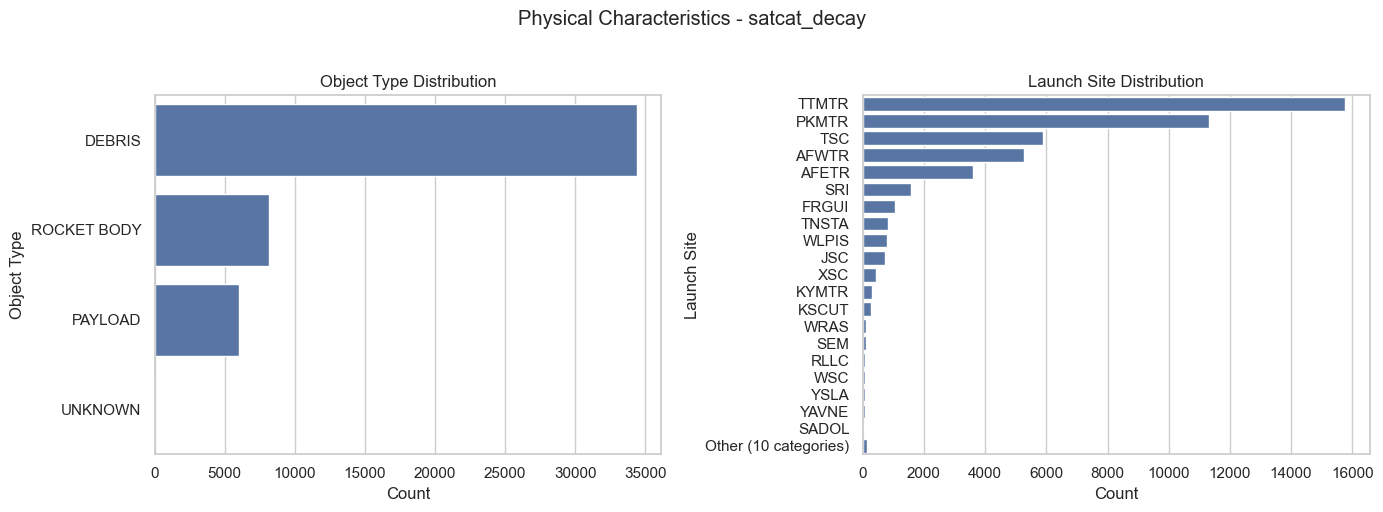

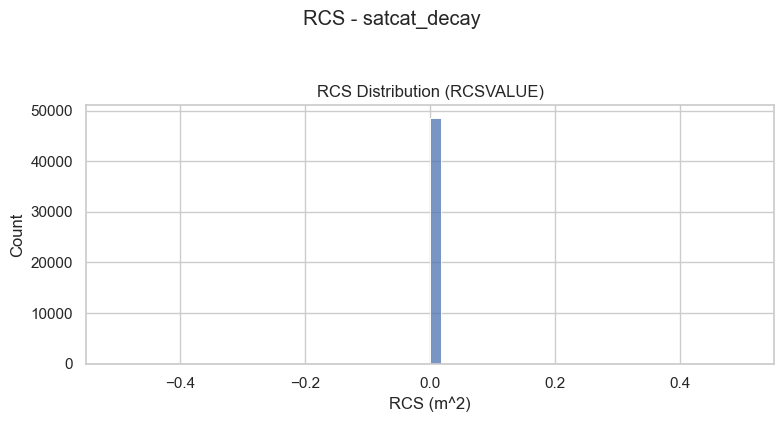

In [36]:

# Helper functions for categorical plots

def _clean_categorical(series: pd.Series) -> pd.Series:
    s = pd.Series(series)
    # Normalize to string, strip whitespace
    s = s.astype(str).str.strip()
    # Treat typical empties as NaN
    s = s.replace({"": np.nan, "nan": np.nan, "None": np.nan, "NONE": np.nan})
    # Fill NaN with 'Unknown'
    s = s.fillna("Unknown")
    return s


def plot_bar_top(ax, series, title: str, ylabel: str, top_n: int = 20):
    s = _clean_categorical(pd.Series(series))
    vc = s.value_counts(dropna=False)
    if vc.empty:
        ax.text(0.5, 0.5, "No data", ha="center", va="center")
        ax.set_title(title)
        ax.set_xlabel("Count")
        ax.set_ylabel(ylabel)
        return
    if len(vc) > top_n:
        top = vc.nlargest(top_n)
        other_count = vc.iloc[top_n:].sum()
        other_label = f"Other ({len(vc) - top_n} categories)"
        vc_plot = pd.concat([top, pd.Series({other_label: other_count})])
    else:
        vc_plot = vc
    # Horizontal bar chart for readability
    sns.barplot(x=vc_plot.values, y=vc_plot.index, orient="h", ax=ax, color=sns.color_palette()[0])
    ax.set_title(title)
    ax.set_xlabel("Count")
    ax.set_ylabel(ylabel)


def plot_rcs(ax, df: pd.DataFrame):
    title = "RCS Distribution"
    if "RCSVALUE" in df.columns:
        rcs = pd.to_numeric(df["RCSVALUE"], errors="coerce").dropna()
        if len(rcs) > 0:
            sns.histplot(rcs, bins=60, ax=ax, kde=False, edgecolor=None)
            ax.set_title(title + " (RCSVALUE)")
            ax.set_xlabel("RCS (m^2)")
            return
    if "RCS_SIZE" in df.columns:
        plot_bar_top(ax, df["RCS_SIZE"], title + " (RCS_SIZE)", "RCS Size", top_n=15)
        return
    # Fallback: no RCS data
    ax.text(0.5, 0.5, "No RCS data", ha="center", va="center")
    ax.set_title(title)


# Identify SATCAT-like datasets (containing any of the relevant columns)
phy_cols = {"OBJECT_TYPE", "COUNTRY", "SITE", "RCSVALUE", "RCS_SIZE"}
satcat_datasets = []
for name, df in preprocessed.items():
    if any(c in df.columns for c in phy_cols):
        satcat_datasets.append((name, df))

print("Datasets considered for Physical Characteristics:", [n for n, _ in satcat_datasets])

# Plot Physical Characteristics per relevant dataset
for name, df in satcat_datasets:
    print(f"\nPlotting Physical Characteristics for: {name}")

    # Determine which categorical columns are present
    cats = [("OBJECT_TYPE", "Object Type Distribution", "Object Type"),
            ("COUNTRY", "Country of Origin", "Country"),
            ("SITE", "Launch Site Distribution", "Launch Site")]
    present = [(col, title, ylabel) for col, title, ylabel in cats if col in df.columns]

    if present:
        n = len(present)
        fig, axes = plt.subplots(1, n, figsize=(6*n + 2, 5))
        if n == 1:
            axes = [axes]
        for ax, (col, title, ylabel) in zip(axes, present):
            plot_bar_top(ax, df[col], title, ylabel, top_n=15 if col != "SITE" else 20)
        fig.suptitle(f"Physical Characteristics - {name}", y=1.02)
        fig.tight_layout()

    # RCS figure (if available)
    if ("RCSVALUE" in df.columns) or ("RCS_SIZE" in df.columns):
        fig2, ax2 = plt.subplots(1, 1, figsize=(8, 4))
        plot_rcs(ax2, df)
        fig2.suptitle(f"RCS - {name}", y=1.05)
        fig2.tight_layout()

plt.show()


Temporal Analysis

Datasets considered for Temporal Analysis: ['spacetrack_decay_5y', 'spacetrack_satcat', 'tle_satcat', 'satcat_decay']

Plotting Temporal Analysis for: spacetrack_decay_5y

Plotting Temporal Analysis for: spacetrack_satcat

Plotting Temporal Analysis for: tle_satcat

Plotting Temporal Analysis for: satcat_decay


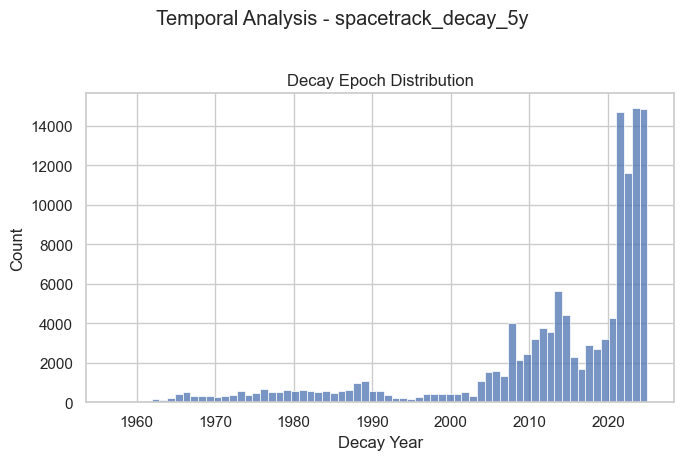

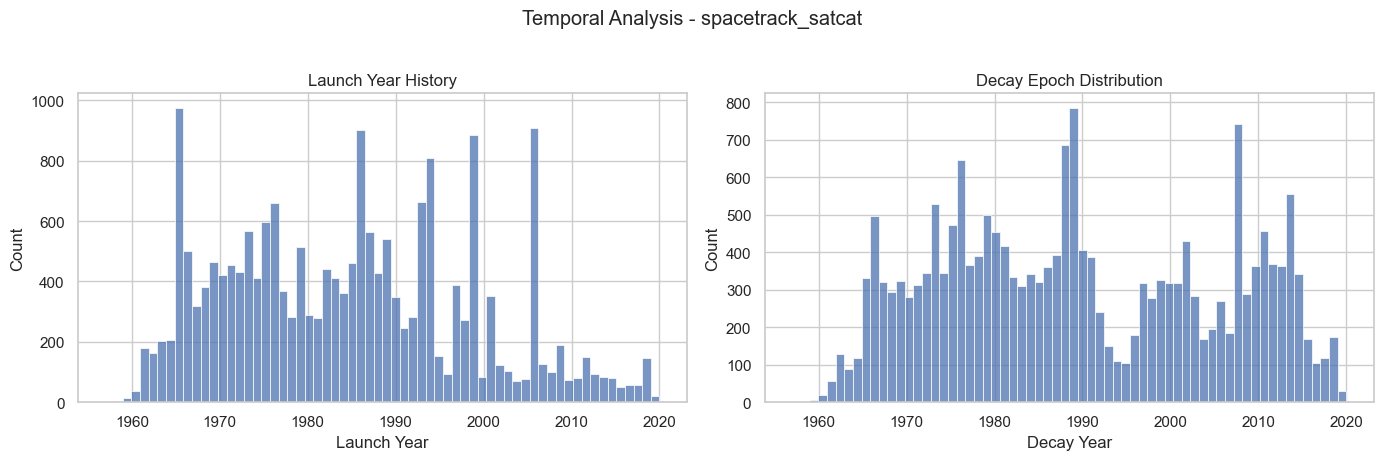

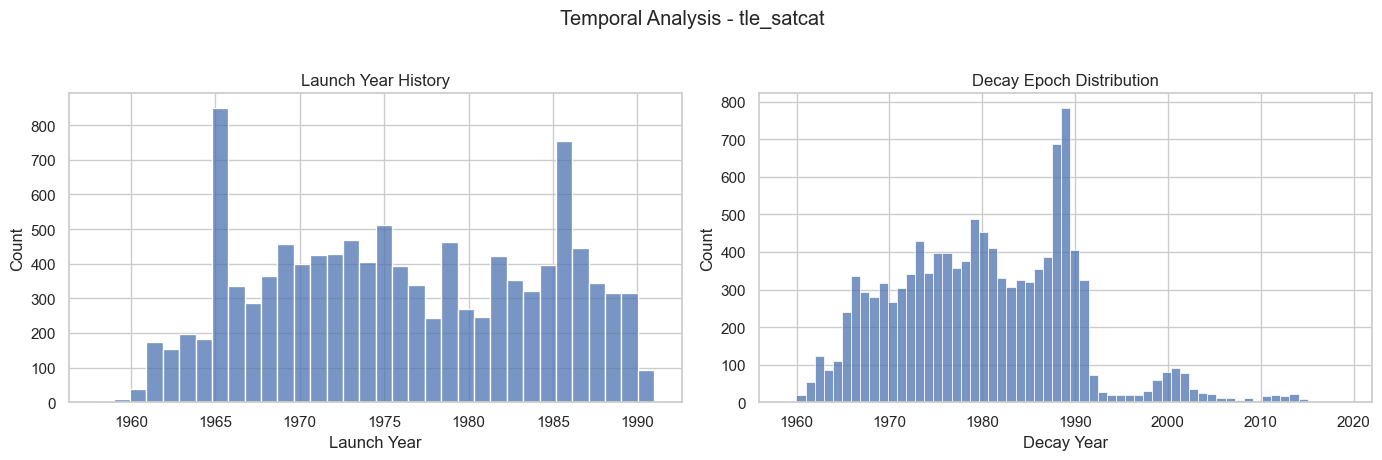

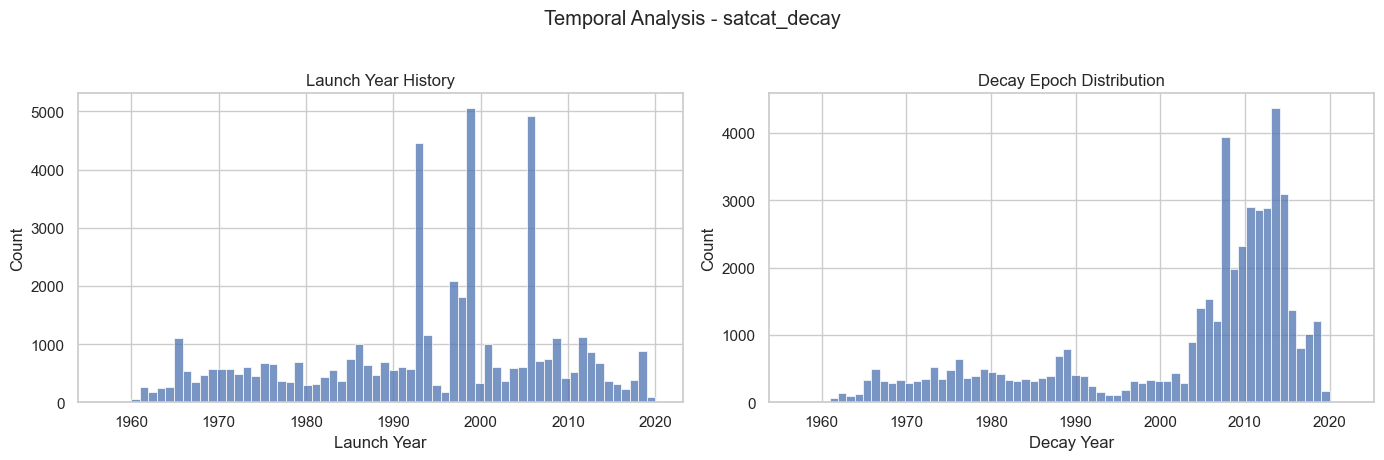

In [38]:

# Helpers for temporal plots

def _extract_year_from_datetime(series: pd.Series) -> pd.Series:
    s = pd.to_datetime(series, errors="coerce", utc=True)
    return s.dt.year


def _plot_year_hist(ax, years: pd.Series, title: str, xlabel: str):
    y = pd.to_numeric(years, errors="coerce").dropna().astype(int)
    if y.empty:
        ax.text(0.5, 0.5, "No data", ha="center", va="center")
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        return
    y_min, y_max = int(y.min()), int(y.max())
    # Reasonable binning: one bin per year if the span is manageable, else cap at 100 bins
    span = max(1, y_max - y_min + 1)
    if span <= 120:
        bins = span
    else:
        bins = 100
    sns.histplot(y, bins=bins, ax=ax, kde=False, edgecolor=None)
    ax.set_title(title)
    ax.set_xlabel(xlabel)


# Identify datasets that contain temporal columns of interest
TEMPORAL_COLS = {"LAUNCH", "LAUNCH_YEAR", "DECAY_EPOCH", "DECAY"}
temporal_datasets = []
for name, df in preprocessed.items():
    if any(c in df.columns for c in TEMPORAL_COLS):
        temporal_datasets.append((name, df))

print("Datasets considered for Temporal Analysis:", [n for n, _ in temporal_datasets])

for name, df in temporal_datasets:
    print(f"\nPlotting Temporal Analysis for: {name}")

    # Launch years: prefer explicit LAUNCH_YEAR; fallback to year from LAUNCH datetime
    launch_years = None
    if "LAUNCH_YEAR" in df.columns:
        launch_years = pd.to_numeric(df["LAUNCH_YEAR"], errors="coerce")
    elif "LAUNCH" in df.columns:
        launch_years = _extract_year_from_datetime(df["LAUNCH"])  # already utc by ensure_datetime

    # Decay years: prefer DECAY_EPOCH; fallback to DECAY
    decay_years = None
    if "DECAY_EPOCH" in df.columns:
        decay_years = _extract_year_from_datetime(df["DECAY_EPOCH"])
    elif "DECAY" in df.columns:
        decay_years = _extract_year_from_datetime(df["DECAY"])  # ensure_datetime handles this too

    # Determine how many subplots we need based on availability
    parts = []
    if isinstance(launch_years, pd.Series):
        parts.append(("Launch Year History", "Launch Year", launch_years))
    if isinstance(decay_years, pd.Series):
        parts.append(("Decay Epoch Distribution", "Decay Year", decay_years))

    if not parts:
        print("  No temporal columns present; skipping.")
        continue

    n = len(parts)
    fig, axes = plt.subplots(1, n, figsize=(7*n, 4.5))
    if n == 1:
        axes = [axes]

    for ax, (title, xlabel, series) in zip(axes, parts):
        _plot_year_hist(ax, series, title, xlabel)

    fig.suptitle(f"Temporal Analysis - {name}", y=1.02)
    fig.tight_layout()

plt.show()


Bivariate and Multivariate Analysis

Datasets considered for Orbital Correlations: ['spacetrack_tle_latest', 'celestrak_debris_tles', 'tle_satcat']

Plotting Correlation Heatmap for: spacetrack_tle_latest

Plotting Correlation Heatmap for: celestrak_debris_tles

Plotting Correlation Heatmap for: tle_satcat


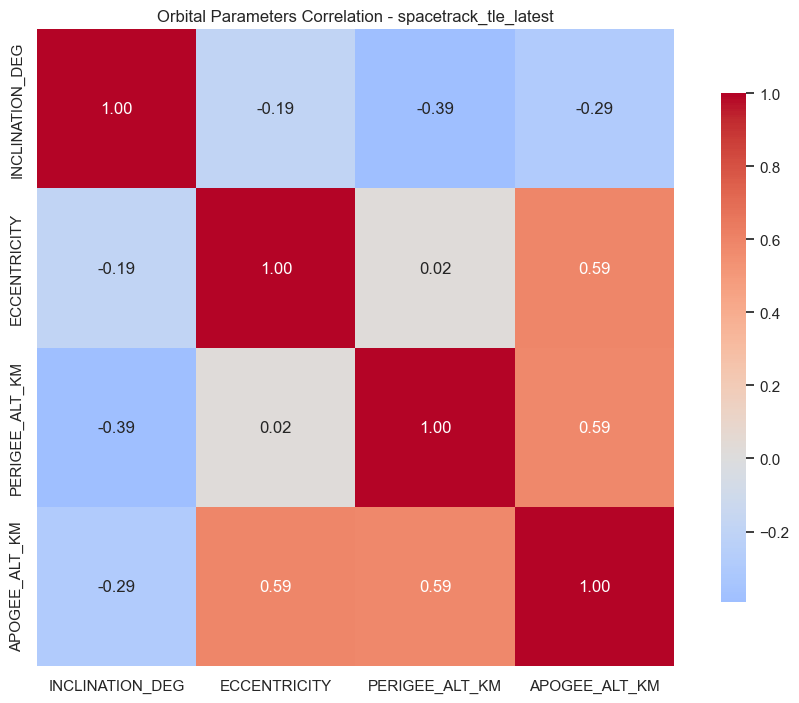

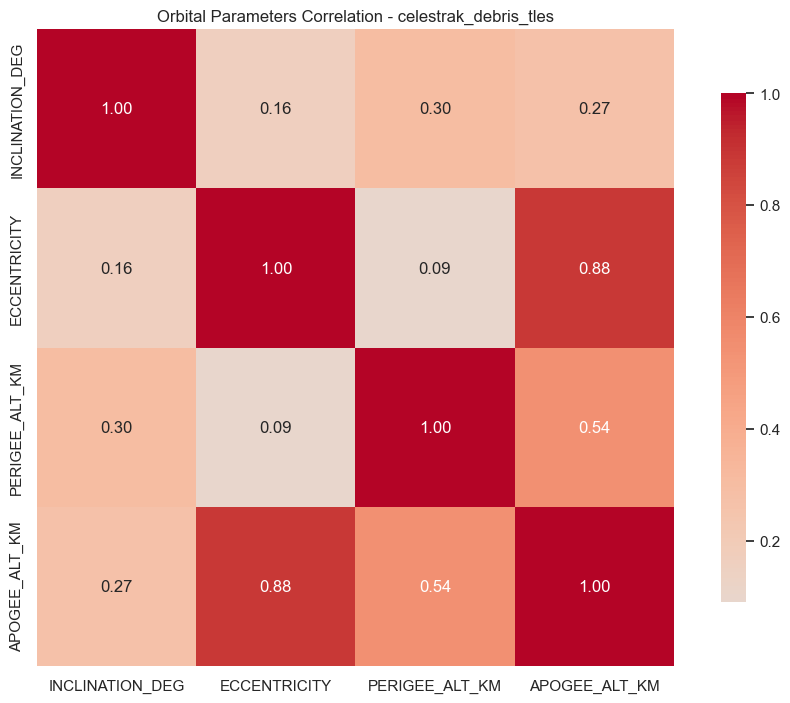

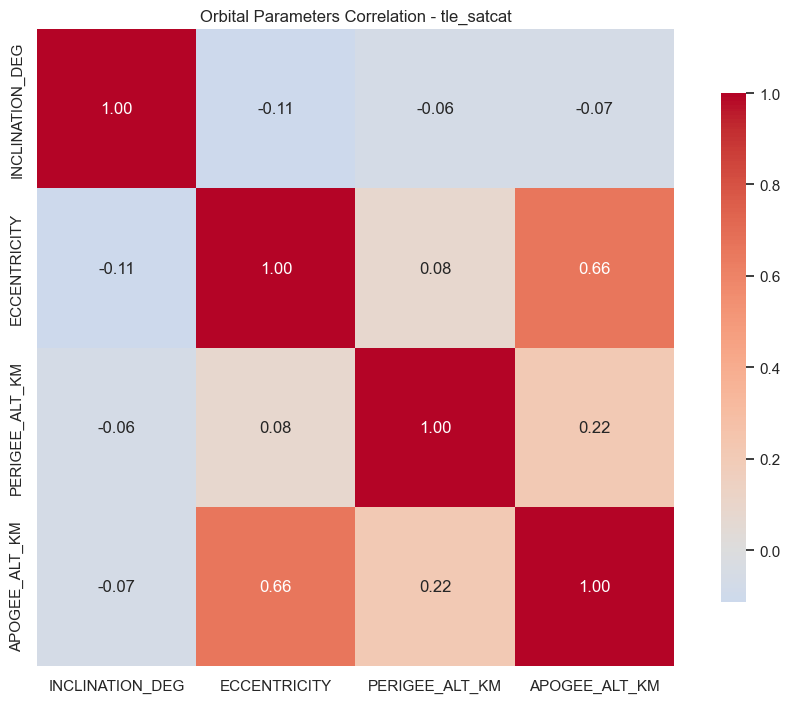

In [39]:

# Correlations: Orbital Parameters
# We'll build correlation matrices for the following columns when present:
#   INCLINATION_DEG, ECCENTRICITY, PERIGEE_ALT_KM, APOGEE_ALT_KM

corr_cols = [
    "INCLINATION_DEG",
    "ECCENTRICITY",
    "PERIGEE_ALT_KM",
    "APOGEE_ALT_KM",
]

corr_datasets = []
for name, df in preprocessed.items():
    available = [c for c in corr_cols if c in df.columns]
    if len(available) >= 2:
        corr_datasets.append((name, available))

print("Datasets considered for Orbital Correlations:", [n for n, _ in corr_datasets])

for name, available in corr_datasets:
    print(f"\nPlotting Correlation Heatmap for: {name}")
    dfnum = preprocessed[name][available].apply(pd.to_numeric, errors="coerce").dropna(how="all")
    # If after coercion we have fewer than 2 valid columns with non-all-NaN, skip.
    valid_cols = [c for c in dfnum.columns if not dfnum[c].isna().all()]
    if len(valid_cols) < 2:
        print("  Not enough valid numeric data; skipping.")
        continue
    corr = dfnum[valid_cols].corr(numeric_only=True)

    plt.figure(figsize=(5 + 1.2*len(valid_cols), 4 + 0.8*len(valid_cols)))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0, square=True,
                cbar_kws={"shrink": 0.8})
    plt.title(f"Orbital Parameters Correlation - {name}")
    plt.tight_layout()

plt.show()


Datasets considered for Debris Count by Launch Year: ['spacetrack_satcat', 'satcat_decay']

Plotting Debris Count by Launch Year for: spacetrack_satcat

Plotting Debris Count by Launch Year for: satcat_decay


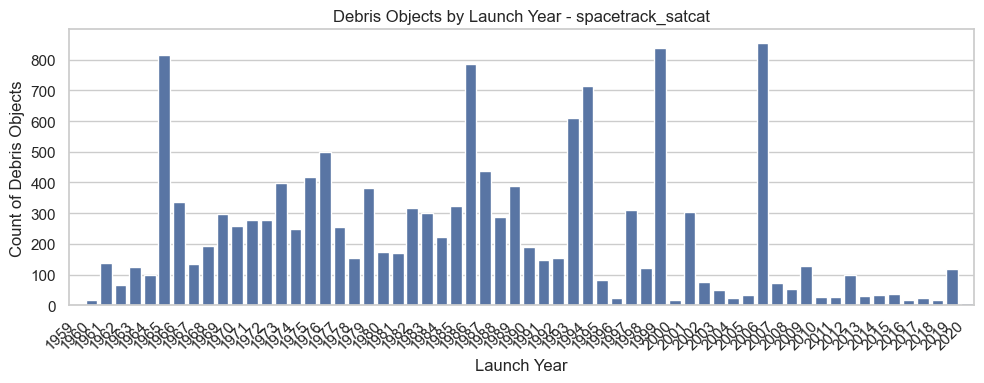

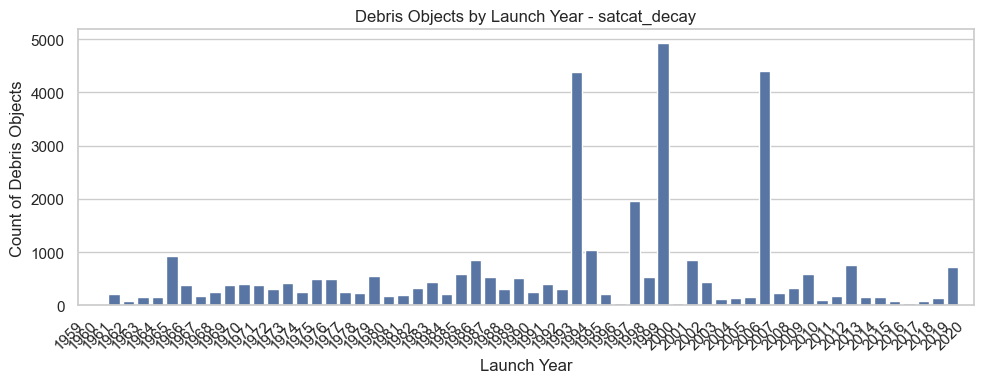

In [40]:

# Launch Year vs. Debris Count
# We consider rows with OBJECT_TYPE indicating debris (contains 'DEB')
# and gather launch year from LAUNCH_YEAR or LAUNCH datetime.

def _extract_year_any(series: pd.Series) -> pd.Series:
    """Extract year from a numeric or datetime-like series robustly."""
    if pd.api.types.is_integer_dtype(series) or pd.api.types.is_float_dtype(series):
        return pd.to_numeric(series, errors="coerce").astype('Int64')
    sdt = pd.to_datetime(series, errors="coerce", utc=True)
    return sdt.dt.year.astype('Int64')


debris_year_datasets = []
for name, df in preprocessed.items():
    if ("OBJECT_TYPE" in df.columns) and ("LAUNCH_YEAR" in df.columns or "LAUNCH" in df.columns):
        debris_year_datasets.append(name)

print("Datasets considered for Debris Count by Launch Year:", debris_year_datasets)

for name in debris_year_datasets:
    print(f"\nPlotting Debris Count by Launch Year for: {name}")
    df = preprocessed[name]

    # Identify debris-like entries by OBJECT_TYPE containing 'DEB'
    obj = df["OBJECT_TYPE"].astype(str).str.upper().fillna("")
    is_debris = obj.str.contains("DEB")

    # Determine launch year
    if "LAUNCH_YEAR" in df.columns:
        years = _extract_year_any(df["LAUNCH_YEAR"]).astype('Int64')
    else:
        years = _extract_year_any(df["LAUNCH"]).astype('Int64')

    debris_years = years[is_debris]
    debris_years = debris_years.dropna()

    if debris_years.empty:
        print("  No debris entries with launch year; skipping.")
        continue

    counts = debris_years.value_counts().sort_index()

    plt.figure(figsize=(10, 4))
    sns.barplot(x=counts.index.astype(int), y=counts.values, color=sns.color_palette()[0])
    plt.title(f"Debris Objects by Launch Year - {name}")
    plt.xlabel("Launch Year")
    plt.ylabel("Count of Debris Objects")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()

plt.show()


Categorical vs. Numerical Analysis

Datasets considered for Country vs. Object Type: ['spacetrack_satcat']

Plotting Country vs. Object Type (stacked) for: spacetrack_satcat


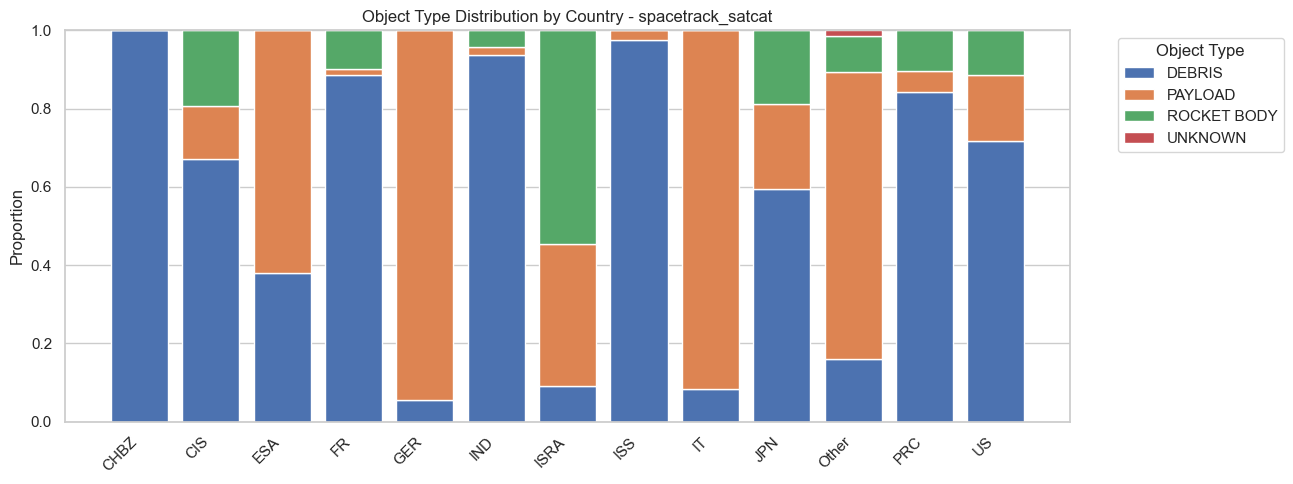

In [41]:

# Helpers for categorical vs numerical plots

def _limit_top_with_other(series: pd.Series, top_n: int = 12, other_label: str = "Other") -> pd.Series:
    s = _clean_categorical(series)
    vc = s.value_counts()
    if len(vc) <= top_n:
        return s
    top = set(vc.nlargest(top_n).index)
    return s.apply(lambda x: x if x in top else other_label)


def _prepare_country_object_type(df: pd.DataFrame, top_countries: int = 12, top_types: int = 12):
    if not ("COUNTRY" in df.columns and "OBJECT_TYPE" in df.columns):
        return None
    countries = _limit_top_with_other(df["COUNTRY"], top_n=top_countries)
    obj_types = _limit_top_with_other(df["OBJECT_TYPE"], top_n=top_types)
    ctab = pd.crosstab(countries, obj_types)
    if ctab.empty:
        return None
    # Normalize per country (row-wise) to proportions
    ctab_prop = ctab.div(ctab.sum(axis=1), axis=0).fillna(0)
    return ctab, ctab_prop


def plot_country_vs_object_type_stacked(ax, ctab_prop: pd.DataFrame, title: str):
    # Use a consistent palette across object types
    categories = list(ctab_prop.columns)
    palette = sns.color_palette(n_colors=len(categories))
    bottom = np.zeros(len(ctab_prop))
    x = np.arange(len(ctab_prop))
    for i, cat in enumerate(categories):
        vals = ctab_prop[cat].values
        ax.bar(x, vals, bottom=bottom, color=palette[i], label=cat)
        bottom += vals
    ax.set_xticks(x)
    ax.set_xticklabels(ctab_prop.index, rotation=45, ha="right")
    ax.set_ylabel("Proportion")
    ax.set_title(title)
    ax.legend(title="Object Type", bbox_to_anchor=(1.04, 1), loc="upper left")


# 1) Country vs. Object Type (stacked bar)
country_objtype_datasets = []
for name, df in preprocessed.items():
    if ("COUNTRY" in df.columns) and ("OBJECT_TYPE" in df.columns):
        country_objtype_datasets.append(name)

print("Datasets considered for Country vs. Object Type:", country_objtype_datasets)

for name in country_objtype_datasets:
    print(f"\nPlotting Country vs. Object Type (stacked) for: {name}")
    df = preprocessed[name]
    prepared = _prepare_country_object_type(df, top_countries=12, top_types=10)
    if prepared is None:
        print("  Not enough data; skipping.")
        continue
    ctab, ctab_prop = prepared
    if ctab_prop.shape[0] == 0 or ctab_prop.shape[1] == 0:
        print("  Empty contingency after processing; skipping.")
        continue
    fig, ax = plt.subplots(1, 1, figsize=(max(8, 0.7*len(ctab_prop.index)+4), 5))
    plot_country_vs_object_type_stacked(ax, ctab_prop, title=f"Object Type Distribution by Country - {name}")
    fig.tight_layout()

plt.show()


Datasets considered for Country vs. Orbital Regimes: ['spacetrack_satcat']

Plotting Apogee vs. Perigee by Country for: spacetrack_satcat


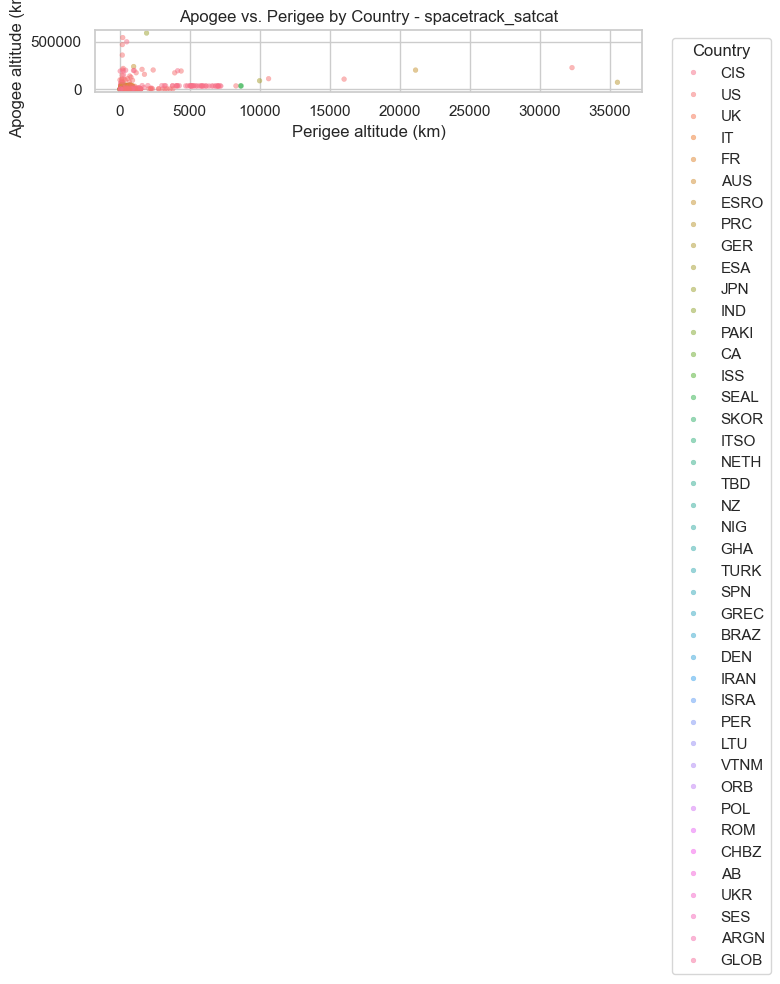

In [43]:

# 2) Country vs. Orbital Regimes: Apogee vs Perigee colored by country
orbital_regime_datasets = []
for name, df in preprocessed.items():
    needed = {"COUNTRY", "PERIGEE", "APOGEE"}
    if needed.issubset(df.columns):
        orbital_regime_datasets.append(name)

print("Datasets considered for Country vs. Orbital Regimes:", orbital_regime_datasets)

for name in orbital_regime_datasets:
    print(f"\nPlotting Apogee vs. Perigee by Country for: {name}")
    df = preprocessed[name].copy()
    # Coerce numeric and drop invalid/negative altitudes
    perigee = pd.to_numeric(df["PERIGEE"], errors="coerce")
    apogee = pd.to_numeric(df["APOGEE"], errors="coerce")
    valid = perigee.notna() & apogee.notna() & (perigee >= 0) & (apogee >= 0)
    df = df.loc[valid, ["COUNTRY", "PERIGEE", "APOGEE"]].copy()
    if df.empty:
        print("  No valid apogee/perigee data; skipping.")
        continue
    df["COUNTRY_LIM"] = _limit_top_with_other(df["COUNTRY"], top_n=10)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=df,
        x="PERIGEE",
        y="APOGEE",
        hue="COUNTRY",
        s=12,
        alpha=0.5,
        edgecolor=None,
    )
    plt.title(f"Apogee vs. Perigee by Country - {name}")
    plt.xlabel("Perigee altitude (km)")
    plt.ylabel("Apogee altitude (km)")
    plt.legend(title="Country", bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.tight_layout()

plt.show()


Datasets considered for Object Type vs. RCS_SIZE (stacked): ['spacetrack_satcat']

Plotting RCS_SIZE distribution by Object Type for: spacetrack_satcat


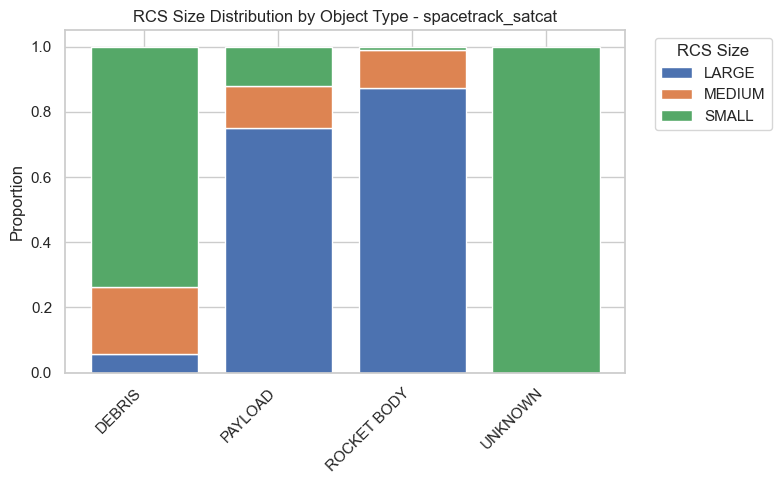

In [47]:

# 3) Object Type vs. RCS_SIZE: Stacked bar of RCS_SIZE distribution by object type
rcs_size_datasets = []
for name, df in preprocessed.items():
    if ("OBJECT_TYPE" in df.columns) and ("RCS_SIZE" in df.columns):
        rcs_size_datasets.append(name)

print("Datasets considered for Object Type vs. RCS_SIZE (stacked):", rcs_size_datasets)

for name in rcs_size_datasets:
    print(f"\nPlotting RCS_SIZE distribution by Object Type for: {name}")
    df = preprocessed[name].copy()
    sub = df[["OBJECT_TYPE", "RCS_SIZE"]].dropna()
    if sub.empty:
        print("  No RCS_SIZE data; skipping.")
        continue
    sub["OBJECT_TYPE_LIM"] = _limit_top_with_other(sub["OBJECT_TYPE"], top_n=12)
    sub["RCS_SIZE_CLEAN"] = _clean_categorical(sub["RCS_SIZE"])

    ctab = pd.crosstab(sub["OBJECT_TYPE_LIM"], sub["RCS_SIZE_CLEAN"])
    if ctab.empty:
        print("  Empty contingency; skipping.")
        continue
    ctab_prop = ctab.div(ctab.sum(axis=1), axis=0).fillna(0)

    fig, ax = plt.subplots(1, 1, figsize=(max(8, 0.7*len(ctab_prop.index)+4), 5))
    categories = list(ctab_prop.columns)
    palette = sns.color_palette(n_colors=len(categories))
    bottom = np.zeros(len(ctab_prop))
    x = np.arange(len(ctab_prop))
    for i, cat in enumerate(categories):
        vals = ctab_prop[cat].values
        ax.bar(x, vals, bottom=bottom, color=palette[i], label=cat)
        bottom += vals
    ax.set_xticks(x)
    ax.set_xticklabels(ctab_prop.index, rotation=45, ha="right")
    ax.set_ylabel("Proportion")
    ax.set_title(f"RCS Size Distribution by Object Type - {name}")
    ax.legend(title="RCS Size", bbox_to_anchor=(1.04, 1), loc="upper left")
    fig.tight_layout()

plt.show()


Phase 4: Conjunction and Risk Analysis (spacetrack_cdm_public_30d)

--- Conjunction Risk Analysis ---
📈 Using suggested PC threshold (99th percentile): 4.89e-03
📉 Using suggested MIN_RNG threshold (5th percentile): 44.000 km

Final Thresholds Used:
  - High PC >= 4.89e-03
  - Small MIN_RNG <= 44.000 km

✅ Found 8 high-risk events out of 4001 total.

📋 Sample of High-Risk Events:


,TCA,PC,MIN_RNG,SAT_1_NAME,SAT_2_NAME
2968,2025-08-17 02:38:18.216000+00:00,3.78e-02,24,SL-8 R/B,CZ-2D R/B
2899,2025-08-17 02:38:18.216000+00:00,2.87e-02,20,SL-8 R/B,CZ-2D R/B
2923,2025-08-17 02:38:18.216000+00:00,2.87e-02,20,CZ-2D R/B,SL-8 R/B
2863,2025-08-17 02:38:18.213000+00:00,2.34e-02,14,SL-8 R/B,CZ-2D R/B
2877,2025-08-17 02:38:18.213000+00:00,2.34e-02,14,CZ-2D R/B,SL-8 R/B
3804,2025-08-21 08:20:32.934000+00:00,1.04e-02,23,PSLV R/B,CZ-6A DEB
3817,2025-08-21 08:20:32.934000+00:00,1.04e-02,23,CZ-6A DEB,PSLV R/B
3773,2025-08-21 08:20:32.928000+00:00,6.53e-03,14,CZ-6A DEB,PSLV R/B


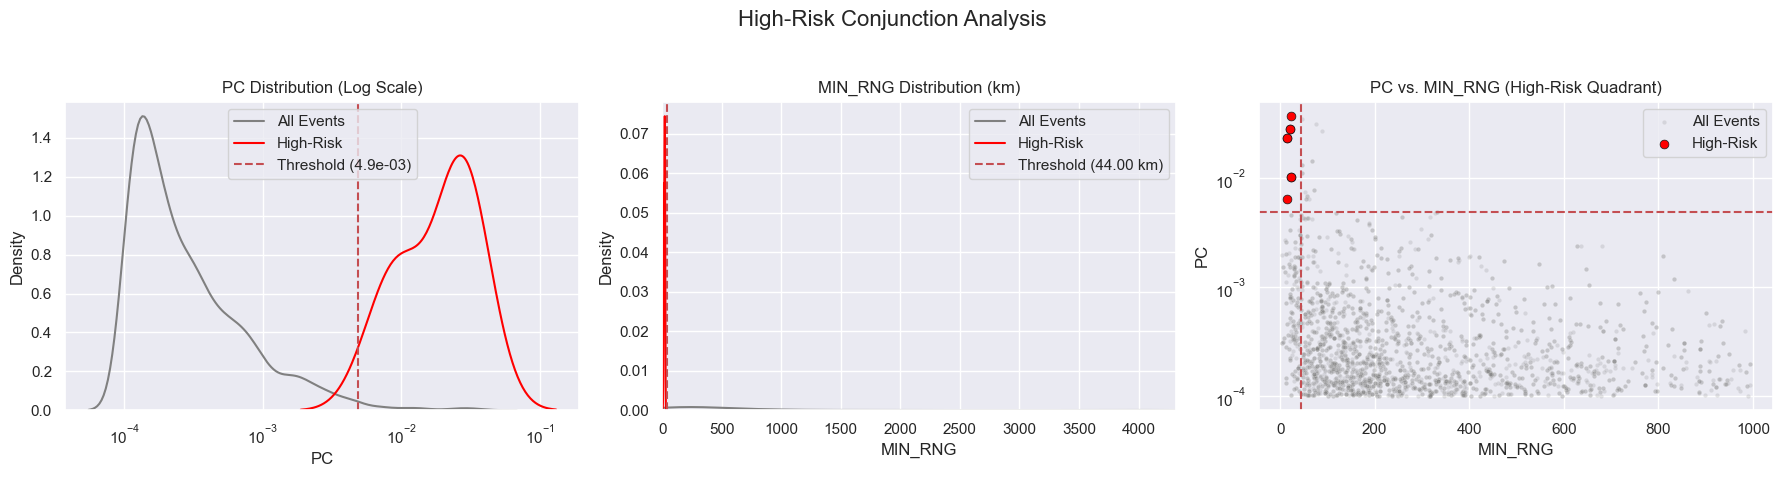

In [59]:
# Helper to find column names robustly (case-insensitive)
def find_col(df, candidates):
    """Finds the first matching column name from a list of candidates, case-insensitively."""
    cols = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand.lower() in cols:
            return cols[cand.lower()]
    return None

def analyze_high_risk_conjunctions(
    cdm_df: pd.DataFrame,
    pc_threshold: float = None,
    rng_threshold_km: float = None,
    use_suggested_thresholds: bool = True
):
    """
    Performs a comprehensive analysis of high-risk conjunctions in a CDM dataset.

    This function identifies high-risk events using adaptive or manual thresholds,
    displays key statistics, and generates insightful visualizations.

    Args:
        cdm_df (pd.DataFrame): The input DataFrame containing conjunction data.
        pc_threshold (float, optional): Manual threshold for Probability of Collision (PC).
        rng_threshold_km (float, optional): Manual threshold for Minimum Range in km.
        use_suggested_thresholds (bool): If True, automatically uses data-driven
            percentiles as thresholds if manual ones aren't provided. This is highly
            recommended to adapt to the dataset's specific distribution.
    """
    if cdm_df is None or cdm_df.empty:
        print("CDM DataFrame is empty. Cannot perform analysis.")
        return

    # 1. --- Column Identification and Data Preparation ---
    pc_col = find_col(cdm_df, ["PC", "PROBABILITY_OF_COLLISION"])
    rng_col = find_col(cdm_df, ["MIN_RNG", "MISS_DISTANCE_KM", "DCA"])
    tca_col = find_col(cdm_df, ["TCA", "TIME_OF_CLOSEST_APPROACH"])

    # Coerce to numeric and datetime, handling potential errors
    if pc_col:
        cdm_df[pc_col] = pd.to_numeric(cdm_df[pc_col], errors="coerce")
    if rng_col:
        cdm_df[rng_col] = pd.to_numeric(cdm_df[rng_col], errors="coerce")
    if tca_col:
        cdm_df[tca_col] = pd.to_datetime(cdm_df[tca_col], errors="coerce", utc=True)

    if pc_col is None or rng_col is None:
        print("⚠️ Critical columns (PC or MIN_RNG) not found. Cannot perform risk analysis.")
        return

    print("--- Conjunction Risk Analysis ---")

    # 2. --- Adaptive Threshold Calculation ---
    s_pc = cdm_df[pc_col].dropna()
    s_rng = cdm_df[rng_col].dropna()

    if use_suggested_thresholds:
        # If no manual threshold is given, suggest and use a percentile-based one
        if pc_threshold is None and not s_pc.empty:
            pc_threshold = float(s_pc.quantile(0.99)) # Top 1% of collision probabilities
            print(f"📈 Using suggested PC threshold (99th percentile): {pc_threshold:.2e}")
        if rng_threshold_km is None and not s_rng.empty:
            rng_threshold_km = float(s_rng.quantile(0.05)) # Closest 5% of approaches
            print(f"📉 Using suggested MIN_RNG threshold (5th percentile): {rng_threshold_km:.3f} km")

    # Fallback to hardcoded defaults if suggestions can't be computed
    HR_PC_THRESHOLD = pc_threshold if pc_threshold is not None else 1e-5
    HR_MINRNG_THRESHOLD_KM = rng_threshold_km if rng_threshold_km is not None else 0.5

    print(f"\nFinal Thresholds Used:")
    print(f"  - High PC >= {HR_PC_THRESHOLD:.2e}")
    print(f"  - Small MIN_RNG <= {HR_MINRNG_THRESHOLD_KM:.3f} km")

    # 3. --- High-Risk Filtering (using AND logic) ---
    mask_pc = cdm_df[pc_col] >= HR_PC_THRESHOLD
    mask_rng = cdm_df[rng_col] <= HR_MINRNG_THRESHOLD_KM
    high_risk_mask = mask_pc & mask_rng # Intersection is more robust for "high-risk"

    high_risk = cdm_df.loc[high_risk_mask].copy()

    print(f"\n✅ Found {len(high_risk)} high-risk events out of {len(cdm_df)} total.")

    if len(high_risk) == 0:
        print("No events met the specified criteria. Consider relaxing thresholds or checking data.")
        return

    # 4. --- Display High-Risk Events Table ---
    cols_to_show = [c for c in [
        tca_col, pc_col, rng_col,
        find_col(cdm_df, ["SAT_1_NAME"]), find_col(cdm_df, ["SAT_2_NAME"]),
        find_col(cdm_df, ["REL_SPEED"])
    ] if c is not None]

    print("\n📋 Sample of High-Risk Events:")
    display(high_risk[cols_to_show].sort_values(by=pc_col, ascending=False).head(10).style.format({pc_col: "{:.2e}"}))

    # 5. --- Visualizations with Threshold Context ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('High-Risk Conjunction Analysis', fontsize=16)

    # PC Distribution
    sns.kdeplot(s_pc, ax=axes[0], label='All Events', color='gray', log_scale=True)
    if not high_risk[pc_col].dropna().empty:
        sns.kdeplot(high_risk[pc_col].dropna(), ax=axes[0], label='High-Risk', color='red', log_scale=True)
    axes[0].axvline(HR_PC_THRESHOLD, color='r', linestyle='--', label=f'Threshold ({HR_PC_THRESHOLD:.1e})')
    axes[0].set_title('PC Distribution (Log Scale)')
    axes[0].legend()

    # MIN_RNG Distribution
    sns.kdeplot(s_rng, ax=axes[1], label='All Events', color='gray')
    if not high_risk[rng_col].dropna().empty:
        sns.kdeplot(high_risk[rng_col].dropna(), ax=axes[1], label='High-Risk', color='red')
    axes[1].axvline(HR_MINRNG_THRESHOLD_KM, color='r', linestyle='--', label=f'Threshold ({HR_MINRNG_THRESHOLD_KM:.2f} km)')
    axes[1].set_title('MIN_RNG Distribution (km)')
    axes[1].set_xlim(left=0, right=max(s_rng.quantile(0.95), HR_MINRNG_THRESHOLD_KM * 2)) # Zoom in on relevant range
    axes[1].legend()

    # PC vs MIN_RNG Scatter Plot
    sns.scatterplot(data=cdm_df, x=rng_col, y=pc_col, ax=axes[2], color='gray', alpha=0.2, s=10, label='All Events')
    sns.scatterplot(data=high_risk, x=rng_col, y=pc_col, ax=axes[2], color='red', s=40, edgecolor='k', label='High-Risk')
    axes[2].set_yscale('log')
    axes[2].axhline(HR_PC_THRESHOLD, color='r', linestyle='--')
    axes[2].axvline(HR_MINRNG_THRESHOLD_KM, color='r', linestyle='--')
    axes[2].set_title('PC vs. MIN_RNG (High-Risk Quadrant)')
    axes[2].legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # 6. --- Operational Urgency: Time-to-TCA Analysis ---
    if tca_col and pd.Timestamp.now(tz='utc'):
        now = pd.Timestamp.now(tz='utc')
        high_risk['TIME_TO_TCA_H'] = (high_risk[tca_col] - now) / pd.Timedelta(hours=1)

        # Filter for future events
        future_events = high_risk[high_risk['TIME_TO_TCA_H'] > 0]

        if not future_events.empty:
            plt.figure(figsize=(10, 4))
            bins = [0, 24, 48, 72, 168, future_events['TIME_TO_TCA_H'].max()]
            labels = ['<24h', '24-48h', '48-72h', '3-7 days', '>7 days']

            time_dist = pd.cut(future_events['TIME_TO_TCA_H'], bins=bins, labels=labels, right=False).value_counts().sort_index()

            sns.barplot(x=time_dist.index, y=time_dist.values)
            plt.title('Operational Urgency: When High-Risk Events Occur')
            plt.xlabel('Time to Closest Approach (TCA)')
            plt.ylabel('Number of High-Risk Events')
            plt.tight_layout()
            plt.show()

cdm_df = preprocessed['spacetrack_cdm_public_30d']
# Run the analysis with adaptive thresholds (recommended)
analyze_high_risk_conjunctions(cdm_df)


PC Distribution (Log Scale)
This plot shows the distribution of the Probability of Collision (PC) for all events versus the high-risk ones.

What it tells you: It helps you see if your filter is correctly isolating the events with the highest probability of collision.

X-Axis (Log Scale): The Probability of Collision. It's on a logarithmic scale because PC values span many orders of magnitude (e.g., from 1×10
−9
  to 1×10
−4
 ). This scale makes it possible to see the entire range clearly.

Gray Curve ('All Events'): Represents the PC distribution for every conjunction in your dataset. You'll typically see a large peak at very low probabilities.

Red Curve ('High-Risk'): Shows the PC distribution for only the events that your script flagged as high-risk.

Red Dashed Line ('Threshold'): This is the exact PC value you used as a cutoff.

How to read it: You should see the red curve shifted far to the right of the gray curve, concentrated at or beyond the red threshold line. This visually confirms that your high-risk group is composed of the events with statistically rare, high collision probabilities.

MIN_RNG Distribution (km)
This plot shows the distribution of the Minimum Range (miss distance) for all events versus the high-risk ones.

What it tells you: It shows whether your high-risk events are, in fact, the ones with the closest predicted approaches.

X-Axis: The miss distance in kilometers (km). Smaller values are more dangerous.

Gray Curve ('All Events'): The distribution for all events in the dataset.

Red Curve ('High-Risk'): The distribution for only the high-risk events.

Red Dashed Line ('Threshold'): The maximum miss distance (e.g., 0.5 km) that you defined for an event to be considered high-risk.

How to read it: The red curve should be concentrated on the far left of the plot, at or to the left of the red threshold line. This means your filter is successfully identifying the conjunctions where the objects are predicted to pass dangerously close to each other.

PC vs. MIN_RNG (High-Risk Quadrant)
This scatter plot is arguably the most important one, as it visualizes both risk criteria at the same time.

What it tells you: It pinpoints exactly which events are the most critical by showing the relationship between their collision probability and miss distance.

Each Dot: Represents a single conjunction event.

X-Axis: Minimum Range (km). Events to the left are closer.

Y-Axis (Log Scale): Probability of Collision. Events toward the top are more probable.

Red Dashed Lines: These lines represent your thresholds and divide the plot into four quadrants.

How to read it: The top-left quadrant is the "High-Risk Zone." Any event falling in this box is dangerous because it has both a high probability of collision and a small miss distance. The red dots (your high-risk events) should appear exclusively inside this box. This plot provides an immediate, intuitive visual summary of the overall risk landscape.

Operational Urgency: When High-Risk Events Occur
This bar chart adds a critical time dimension to the analysis.

What it tells you: It answers the question, "How much time do we have before these high-risk events happen?"

X-Axis: Time categories showing how far in the future the Time of Closest Approach (TCA) is (e.g., within 24 hours, 24-48 hours, etc.).

Y-Axis: The number of high-risk events that fall into each time category.

How to read it: This plot helps prioritize action. A high number of events in the <24h bar is a major red flag 🚩, indicating that immediate attention and potential satellite maneuvers may be required. Events happening more than a week out are still tracked but are less urgent.